# Part 1

In [15]:
import datetime
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt

from pylab import mpl, plt

import scipy.optimize as sco

import yfinance as yf
import pandas_datareader as pdr

In [ ]:
raw = pd.read_csv('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/etf-reproducible-finance.csv',
                  index_col=0, parse_dates=True).dropna() 

In [2]:
rets = raw.pct_change().dropna()

noa = 5

ann_rets = rets.mean() * 252

def port_ret(weights):
    return np.sum(ann_rets * weights)

def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

def min_func_sharpe(weights):  
    return -port_ret(weights) / port_vol(weights)  

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})  

bnds = tuple((0, 1) for x in range(noa))  

eweights = np.array(noa * [1. / noa,])  

opt_max_sharpe = sco.minimize(min_func_sharpe, eweights,
                    method='SLSQP', bounds=bnds,
                    constraints=cons) 

opt_gmv = sco.minimize(port_vol, eweights,
                    method='SLSQP', bounds=bnds,
                    constraints=cons)  

rets_max_sharpe_weighted = rets.mul(opt_max_sharpe.x, axis=1)
rets_max_sharpe_weighted['portfolio'] = rets_max_sharpe_weighted.sum(axis=1)

rets_gmv_weighted = rets.mul(opt_gmv.x, axis=1)
rets_gmv_weighted['portfolio'] = rets_gmv_weighted.sum(axis=1)

In the lab instructions, I mention the Max Sharpe portfolio. But, then I ask you to find the VaRs for the **two optimal portfolios**. Back in Lab 05, I had you find the Max Sharpe and the Min Volatility portfolios.

In [3]:
#Non-Parametric VaRs

# Max Sharpe
ms_var_95 = np.percentile(rets_max_sharpe_weighted['portfolio'], 100 - 95)
ms_var_99 = np.percentile(rets_max_sharpe_weighted['portfolio'], 100 - 99)

# GMV
gmv_var_95 = np.percentile(rets_gmv_weighted['portfolio'], 100 - 95)
gmv_var_99 = np.percentile(rets_gmv_weighted['portfolio'], 100 - 99)

#Non-Parametric CVaRs

# Max Sharpe
ms_cvar_95= rets_max_sharpe_weighted['portfolio'][rets_max_sharpe_weighted['portfolio'] <= ms_var_95].mean()
ms_cvar_99= rets_max_sharpe_weighted['portfolio'][rets_max_sharpe_weighted['portfolio'] <= ms_var_99].mean()

# GMV
gmv_cvar_95= rets_gmv_weighted['portfolio'][rets_gmv_weighted['portfolio'] <= gmv_var_95].mean()
gmv_cvar_99= rets_gmv_weighted['portfolio'][rets_gmv_weighted['portfolio'] <= gmv_var_99].mean()

In [4]:
print(ms_var_95)
print(ms_var_99)

print(gmv_var_95)
print(gmv_var_99)

print(ms_cvar_95)
print(ms_cvar_99)

print(gmv_cvar_95)
print(gmv_cvar_99)

-0.0038548508691317214
-0.006916379946471858
-0.0030611910762612005
-0.004827906052867598
-0.005709655889728831
-0.008939650227734994
-0.00429904702704899
-0.006682941054939489


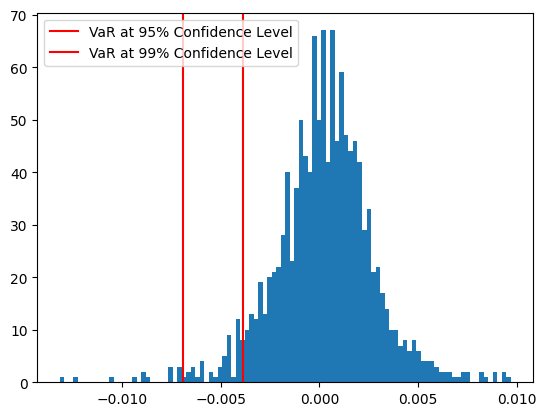

In [5]:
plt.hist(rets_max_sharpe_weighted['portfolio'], bins = 100)
plt.axvline(x = ms_var_95, c='r', label = "VaR at 95% Confidence Level")
plt.axvline(x = ms_var_99, c='r', label = "VaR at 99% Confidence Level")
plt.legend();

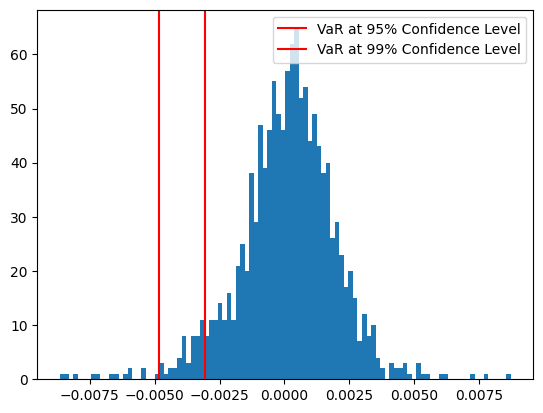

In [6]:
plt.hist(rets_gmv_weighted['portfolio'], bins = 100)
plt.axvline(x = gmv_var_95, c='r', label = "VaR at 95% Confidence Level")
plt.axvline(x = gmv_var_99, c='r', label = "VaR at 99% Confidence Level")
plt.legend();

The issue with this sort of risk analysis is that you're using **historical data**. You have to believe that actual, obserserved returns are a good guide to future risk. This might be true! But, knowing how much history to include can be an issue.

## Part 2

I'd mentioned using `pandas-data-reader` to pull in tickers. I think that using **Yahoo! Finance** directly, as we did in Lab05, probably works better now.

You can read more here <https://pypi.org/project/yfinance/>. Scroll down to **multiple tickers** to see what I'm doing here. ChatGPT would also give you code like this.

In short, there are multiple ways to get data from Yahoo! Finance. Their syntax varies, as does the format that they return data in.

In [17]:
# Define the list of tickers, the start date, and the end date
ticker_list = ["AAPL", "F", "MSFT", "XOM"]
start_date = "2014-01-01"
end_date = "2024-04-30"

# Fetch the data for all tickers
data = yf.download(ticker_list, start=start_date, end=end_date)


[*********************100%%**********************]  4 of 4 completed


In [18]:
data

Price        Adj Close                                          Close         \
Ticker            AAPL          F        MSFT         XOM        AAPL      F   
Date                                                                           
2014-01-02   17.273235   9.181998   31.233067   64.282150   19.754642  15.44   
2014-01-03   16.893808   9.223626   31.022934   64.127510   19.320715  15.51   
2014-01-06   16.985933   9.265254   30.367340   64.224174   19.426071  15.58   
2014-01-07   16.864447   9.146315   30.602703   65.132828   19.287144  15.38   
2014-01-08   16.971254   9.241466   30.056360   64.920120   19.409286  15.54   
...                ...        ...         ...         ...         ...    ...   
2024-04-23  166.673920  12.784719  407.570007  121.029999  166.899994  12.94   
2024-04-24  168.791061  12.794600  409.059998  121.050003  169.020004  12.95   
2024-04-25  169.659882  12.883519  399.040009  121.330002  169.889999  13.04   
2024-04-26  169.070679  12.636519  406.320007  117.959999  169.300003  12.79   
2024-04-29  173.264984  12.597000  402.250000  119.639999  173.500000  12.75   

Price                                     High         ...         Low  \
Ticker            MSFT         XOM        AAPL      F  ...        MSFT   
Date                                                   ...               
2014-01-02   37.160000   99.750000   19.893929  15.45  ...   37.099998   
2014-01-03   36.910000   99.510002   19.775000  15.64  ...   36.599998   
2014-01-06   36.130001   99.660004   19.528570  15.76  ...   36.110001   
2014-01-07   36.410000  101.070000   19.498571  15.74  ...   36.209999   
2014-01-08   35.759998  100.739998   19.484285  15.71  ...   35.580002   
...                ...         ...         ...    ...  ...         ...   
2024-04-23  407.570007  121.029999  167.050003  13.05  ...  403.059998   
2024-04-24  409.059998  121.050003  169.300003  13.05  ...  406.779999   
2024-04-25  399.040009  121.330002  170.610001  13.18  ...  388.029999   
2024-04-26  406.320007  117.959999  171.339996  13.02  ...  405.760010   
2024-04-29  402.250000  119.639999  176.029999  12.84  ...  399.190002   

Price                         Open                                    Volume  \
Ticker             XOM        AAPL      F        MSFT         XOM       AAPL   
Date                                                                           
2014-01-02   99.389999   19.845715  15.42   37.349998  100.599998  234684800   
2014-01-03   99.139999   19.745001  15.52   37.200001   99.769997  392467600   
2014-01-06   98.889999   19.194643  15.72   36.849998   99.940002  412610800   
2014-01-07   99.419998   19.440001  15.73   36.330002   99.610001  317209200   
2014-01-08  100.150002   19.243214  15.60   36.000000  101.190002  258529600   
...                ...         ...    ...         ...         ...        ...   
2024-04-23  119.449997  165.350006  13.05  404.239990  120.000000   49537800   
2024-04-24  119.389999  166.539993  12.94  409.559998  120.300003   48251800   
2024-04-25  119.400002  169.529999  12.85  394.029999  121.029999   50558300   
2024-04-26  116.220001  169.880005  12.76  412.170013  119.000000   44838400   
2024-04-29  117.760002  173.369995  12.81  405.250000  117.760002   68169400   

Price                                     
Ticker             F      MSFT       XOM  
Date                                      
2014-01-02  31528500  30632200  11028100  
2014-01-03  46122300  31134800   9295600  
2014-01-06  42657600  43603700  11848500  
2014-01-07  54476300  35802800  11187000  
2014-01-08  48448300  59971700  11180400  
...              ...       ...       ...  
2024-04-23  62807100  15734500  13929800  
2024-04-24  74510400  15065300  12101200  
2024-04-25  86944100  40586500  16041000  
2024-04-26  57257800  29694700  27289500  
2024-04-29  50285600  19582100  17309900  

[2598 rows x 24 columns]

This dataframe has **multiple indices**. See how there's two rows for the different columns at the top? There's a variable, like **Adj. Close**, and then the four tickers for each variable. We just want the **adjusted close** to find returns. 

See the notes for more on using multiple indices in a `pandas` dataframe.

In [19]:
prices = data['Adj Close']

rets = prices.pct_change().dropna()

In [20]:
rets

Ticker,AAPL,F,MSFT,XOM
Date,,,,
2014-01-03,-0.021966,0.004534,-0.006728,-0.002406
2014-01-06,0.005453,0.004513,-0.021133,0.001507
2014-01-07,-0.007152,-0.012837,0.007751,0.014148
2014-01-08,0.006333,0.010403,-0.017853,-0.003266
2014-01-09,-0.012770,0.019305,-0.006432,-0.009728
...,...,...,...,...
2024-04-23,0.006392,0.004658,0.016485,0.003898
2024-04-24,0.012702,0.000773,0.003656,0.000165
2024-04-25,0.005147,0.006950,-0.024495,0.002313


Let's define some useful objects describing these returns.

In [29]:
mu = rets.mean()
cov = rets.cov()
sigma = rets.std()
corr = rets.corr()

In [30]:
T = 100 # How long is our simulation? Let's do 100 days.
N = 100 # number of time points in the prediction time horizon, making this the same as T means that we will simulate daily returns 
dt = T/N # daily steps
noa = 4 # Number of assets
N_SIM = 1

weights = np.array(noa * [1. / noa,])  # EW portfolio based on number of assets. You can change this array to have any weights you want.

port_returns_all = np.full((T-1, N_SIM), 0.) # One less return than price

S_0 = prices.iloc[-1]
A = np.linalg.cholesky(cov)
S = np.zeros([noa, N])
S[:, 0] = S_0

for i in range(1, N):    
    drift = (mu - 0.5 * sigma**2) * dt # dt = 1. This is the deterministic part of the daily return. It's the same every day.
    Z = np.random.normal(0., 1., noa) # Putting as period after a number in Python makes division work correctly when dealing with integers. Not sure we even need it here.
    diffusion = np.matmul(A, Z) * np.sqrt(dt) # dt = 1. This is the random part. 
    S[:, i] = S[:, i-1]*np.exp(drift + diffusion) # S_t = S_t-1 * e^(r). Continuous compounding, where r is just that day's return, rather than a cumulative return. 

R = pd.DataFrame(S.T).pct_change().dropna() # Create returns from those simulated prices.

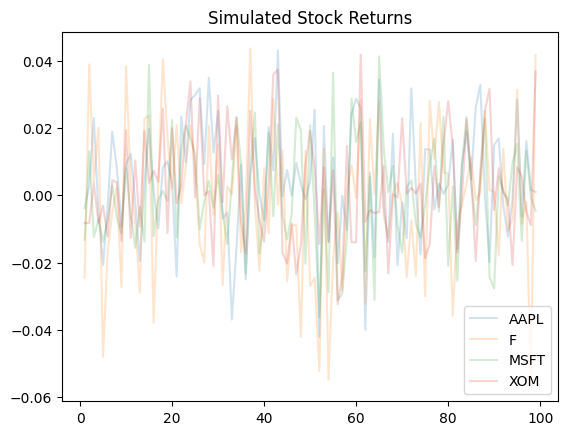

In [31]:
# plotting
column_names=["AAPL", "F", "MSFT", "XOM"]
R.columns = column_names

ax = R.plot(alpha=0.2, legend=False)
ax.set_title('Simulated Stock Returns', fontsize=12)
plt.legend();

## Part 3

In [32]:
T = 100 # How long is our simulation? Let's do 100 days.
N = 100 # number of time points in the prediction time horizon, making this the same as T means that we will simulate daily returns 
dt = T/N # daily steps
noa = 4 # Number of assets
N_SIM = 100

weights = np.array(noa * [1. / noa,])  # EW portfolio based on number of assets. You can change this array to have any weights you want.

port_returns_all = np.full((T-1, N_SIM), 0.) # One less return than price

S_0 = prices.iloc[-1]
A = np.linalg.cholesky(cov)
S = np.zeros([noa, N])
S[:, 0] = S_0

for t in range(0, N_SIM):
    for i in range(1, N):    
        drift = (mu - 0.5 * sigma**2) * dt 
        Z = np.random.normal(0., 1., noa) 
        diffusion = np.matmul(A, Z) * np.sqrt(dt) 
        S[:, i] = S[:, i-1]*np.exp(drift + diffusion) 

        R = pd.DataFrame(S.T).pct_change().dropna()

        port_rets = np.cumprod(np.inner(weights, R) + 1)
    port_returns_all[:, t] = port_rets
    
port_returns_all = pd.DataFrame(port_returns_all)

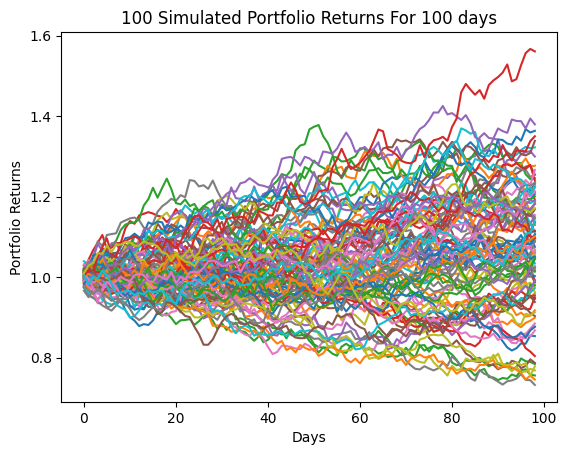

In [33]:
plt.plot(port_returns_all)
plt.ylabel('Portfolio Returns')
plt.xlabel('Days')
plt.title('100 Simulated Portfolio Returns For 100 days');

## Part 4

In [35]:
def bsm_put_value(S, K, T, r, sigma):
    
    ''' Valuation of European call option in BSM model.
    Analytical formula.
    Parameters
    ==========
    S0: float
    initial stock/index level
    K: float
    T: float
    maturity date (in year fractions)
    r: float
    constant risk-free short rate
    sigma: float
    volatility factor in diffusion term
    Returns
    =======
    value: float
    present value of the European call option
    '''
    
    from math import log, sqrt, exp
    from scipy import stats
    
    S = float(S) # This is the current stock price. float() just makes sure that it is that type of number, and not in integer.
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    # stats.norm.cdf --> cumulative distribution function
    # for normal distribution
    value = (K * exp(-r * T) * stats.norm.cdf(-d2, 0.0, 1.0) - S * stats.norm.cdf(-d1, 0.0, 1.0))
    return value

In [36]:
aapl_cov = cov.iloc[0,0]
aapl_cov

0.0003154397954468057

In [37]:
vol = np.sqrt(aapl_cov * 252)
vol

0.2819411790650579

In [38]:
bsm_put_value(186.92, 210, 3/365, 0.03, vol)

23.02822837521458

The price on Yahoo! Finance for this option to sell Apple for $210 in 3 days, when it is currently trading at $186.92, was $22.55. The Black-Scholes model, assuming a volatility of 28.19% and a risk-free rate of 3%, gives me a price of $23.03. Close!